In [1]:
from collections import Counter
import itertools
import math
import networkx as nx
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

## Read data
Read all cities dataset and load into NetworkX

In [2]:
# data source: https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html
datafile = '../data/uscap_xy.txt'
nodes = []
G = nx.Graph(agents=[])
i = 0
with open(datafile, 'r', encoding='UTF-8') as file:
    while (line := file.readline().rstrip()):
        coords = line.split()
        G.add_node(i, x=float(coords[0]), y=float(coords[1]))
    
        # increment counter
        i += 1

## Calculate distance between every edge
Create a list of all combinations of nodes then calculate distances based on x, y values

In [3]:
num_nodes = len(G.nodes())
node_pairs = list(itertools.combinations(G.nodes(), 2))

print("number of nodes: \t", num_nodes)
print("number of node pairs: \t", len(node_pairs))

number of nodes: 	 50
number of node pairs: 	 1225


In [4]:
# calculate distance between every node and store that as an edge value
for i, pair in enumerate(node_pairs):
    x_1 = G.nodes()[pair[0]]["x"]
    y_1 = G.nodes()[pair[0]]["y"]
    x_2 = G.nodes()[pair[1]]["x"]
    y_2 = G.nodes()[pair[1]]["y"]

    distance = np.sqrt(pow((x_2 - x_1), 2) + pow((y_2 - y_1), 2))
    
    pair = pair + (distance,)
    node_pairs[i] = pair

G.add_weighted_edges_from(node_pairs)

In [5]:
# G.edges().data()
# G.nodes().data()

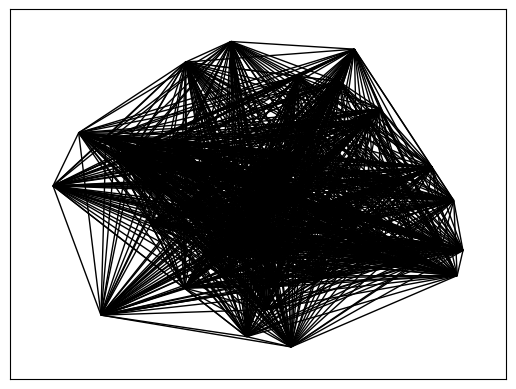

In [6]:
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos)

In [7]:
# G.edges.data('distance')

In [8]:
# adjacency matrix of the graph
G_mat = nx.to_numpy_matrix(G, weight = 'weight')

In [9]:
G_mat[0]

matrix([[   0.        , 3778.48031636, 1783.88533383,  449.20082496,
         2468.84241306, 1389.33543073, 1142.6516462 ,  879.06013125,
          191.39039695,  162.40366599, 5002.231289  , 2211.19702021,
          563.23423492,  513.41993493,  814.86937019,  797.34887221,
          414.92446523,  360.7132201 , 1408.93642607,  815.56076682,
         1255.37725896,  726.58574309,  989.08699188,  271.41479516,
          592.41923478, 2032.8331999 ,  925.61326724, 2360.19250564,
         1264.43340249,  963.78387597, 1379.2242894 , 1118.94297119,
          578.14170759, 1515.24223093,  571.94818681,  807.07155063,
         2683.68811562,  848.9671105 , 1217.06420434,  379.61973002,
         1277.35605783,  265.10800219,  805.69699096, 1862.37718182,
         1254.4474154 ,  706.64738794, 2725.65561098,  523.66735215,
          770.70433962, 1416.47385265]])

In [10]:
# Number of potential routes
print("Number of potential routes: \t", math.factorial(len(G.nodes()) - 1))

Number of potential routes: 	 608281864034267560872252163321295376887552831379210240000000000


In [11]:
len("08281864034267560872252163321295376887552831379210240000000000")

62

## TSP Algorithm

1. Start with a population of agents on the starting node
2. Each step each agent goes to a new node, adds that node to their path, and calculates their total traveled distance
    - Once the agent adds a node to their path history, that node is removed from their set of potential next steps


### Notes

- There should not be more than $(n - 1)!$ agents (where $n$ is the number of nodes) because that is the total number of potential paths

In [12]:
# randomize the starting node
start_node = random.choice(range(num_nodes))
# end_node = 2

num_agents = min(5000, math.factorial(num_nodes - 1)) # max
# num_agents = 1000
print("Number of traveling salesperson agents: \t", num_agents)

Number of traveling salesperson agents: 	 5000


In [13]:
# initialize agents
agents = []
for idx, agent in enumerate(range(num_agents)):
    # create a new agent
    candidate_nodes = set(G.nodes()) - set([start_node])
    agent = {
        "id": idx,
        "current_node": start_node,
        "path": [start_node],
        "candidate_nodes": candidate_nodes,
        "distance_traveled": 0
    }
    agents.append(agent)

In [14]:
# print(agents)

In [15]:
def step():
    #     print("ROUND ", i)
    for agent in agents:
        # if all nodes have been visited then return to start node
        if agent["candidate_nodes"] == set():
            next_node = start_node
        else:
        # choose the next node to go to
            next_node = random.choice(list(agent["candidate_nodes"]))

        # calculate distance to travel
        agent["distance_traveled"] += G_mat[agent["current_node"], next_node]
        # travel from one node to the next
        agent["current_node"] = next_node
        # update path history
        agent["path"].append(agent["current_node"])
        # remove node from candidate nodes
        agent["candidate_nodes"] -= set([next_node])
    # list out which agents are on each node

    # save the state of the network (agent ids and the current node they're on)
    network_state = [(a["id"], a["current_node"]) for a in agents]

    # find nodes with more than one agent on them (for the info exchange)
    node_list = {}
    for idx, current_node in network_state:
        if current_node in node_list:
            node_list[current_node].append((idx, current_node))
        else:
            node_list[current_node] = [(idx, current_node)]

#     print("list of nodes where information exchange happens")
    node_info_exchange_hubs = {k: v for k, v in node_list.items() if len(v) > 1}

    # agents gather to exchange travel stories and each replace their path
    # with the path of the most efficient salesperson in the group
    # start after the first round because all the agents will have traveled the same
    # distance to meet each other - no valuable information
    if i > 0:
        for hub in [(node, agents) for node, agents in node_info_exchange_hubs.items()]:
    #         print("node: \t", i[0])
            agent_neighbors = [agents[id[0]] for id in hub[1]]
    #         print("agents: \t", agent_neighbors)

            # find agent with most efficient path       
            ## list of distances
            agent_neighbors_distances = [(a["id"], a["distance_traveled"]) for a in agent_neighbors]

    #       note:
    #        this weird code `min(agent_neighbors_distances, key = lambda t: t[1]))`
    #        finds the index of the agent with min distance at that node
            agent_most_efficient = min(agent_neighbors_distances, key = lambda t: t[1])

            agent_min_distance_idx = min(agent_neighbors_distances, key = lambda t: t[1])[0]
            agent_min_distance = agents[agent_min_distance_idx]

    #         print("min distance agent: \t", agent_min_distance)
            # replace neighbor agent paths and distances with most efficient path and distance
#             print("agent_min_distance_path: \t", agent_min_distance["path"])
#             print("agent_min_distance_candidate_nodes: \t", agent_min_distance["candidate_nodes"])
#             print("agent_min_distance_distance_traveled: \t", agent_min_distance["distance_traveled"])
            agent_min_distance_path = agent_min_distance["path"]
            agent_min_distance_candidate_nodes = agent_min_distance["candidate_nodes"]
            agent_min_distance_distance_traveled = agent_min_distance["distance_traveled"]

            # replace remaining candidate nodes with candidates nodes of most efficient agent
#             print("## BEFORE INFO REASSIGNEMENT ##")
#             print("agent neighbors: \t", agent_neighbors)

            for a in agent_neighbors:
                # replace information for all agent neighbors with info from the most efficient
                if a["id"] != agent_min_distance_idx and a["candidate_nodes"] != set():
                    a["path"] = agent_min_distance_path.copy()
                    a["candidate_nodes"] = agent_min_distance_candidate_nodes.copy()
                    a["distance_traveled"] = agent_min_distance_distance_traveled.copy()
#             print("## AFTER INFO REASSIGNEMENT ##")
#             print("agent neighbors: \t", agent_neighbors)

    else:
        pass

In [16]:

# choose a random next node to go to
for i in range(num_nodes):
    step()

In [17]:
for p in list(dict(Counter([tuple(a["path"]) for a in agents])).keys()):
    print(nx.path_weight(G, path = p, weight = "weight"))

28844.341481002393
27834.40630240488
25657.340482553485
24321.840269559838


In [18]:
tsp_candidate_paths = [{"path": p, "distance": nx.path_weight(G, path = p, weight = "weight")} for p in dict(Counter([tuple(a["path"]) for a in agents])).keys()]
print(tsp_candidate_paths)

[{'path': (35, 3, 23, 0, 9, 39, 32, 45, 19, 7, 29, 6, 38, 20, 28, 44, 31, 37, 47, 34, 16, 41, 13, 21, 48, 12, 24, 15, 26, 14, 22, 40, 49, 5, 30, 2, 43, 11, 25, 33, 27, 4, 36, 46, 1, 42, 17, 8, 18, 10, 35), 'distance': 28844.341481002393}, {'path': (35, 3, 23, 0, 9, 39, 32, 45, 19, 7, 29, 6, 38, 20, 28, 44, 31, 37, 47, 34, 16, 41, 13, 21, 48, 12, 24, 15, 26, 14, 22, 40, 49, 5, 43, 11, 27, 4, 36, 46, 25, 2, 30, 42, 17, 8, 33, 1, 10, 18, 35), 'distance': 27834.40630240488}, {'path': (35, 3, 23, 0, 9, 39, 32, 45, 19, 7, 29, 6, 38, 20, 28, 44, 31, 37, 47, 34, 16, 41, 13, 21, 48, 12, 24, 15, 26, 14, 22, 40, 49, 5, 43, 11, 27, 4, 36, 46, 25, 2, 30, 42, 17, 8, 18, 33, 1, 10, 35), 'distance': 25657.340482553485}, {'path': (35, 3, 23, 0, 9, 39, 32, 45, 19, 7, 29, 6, 38, 20, 28, 44, 31, 37, 47, 34, 16, 41, 13, 21, 48, 12, 24, 15, 26, 14, 22, 40, 49, 5, 30, 2, 43, 11, 25, 33, 27, 4, 36, 46, 1, 10, 42, 17, 8, 18, 35), 'distance': 24321.840269559838}]


In [19]:
# Minimum path
tsp_shortest_path = min(tsp_candidate_paths, key = lambda x:x["distance"])["path"]
tsp_shortest_distance = min(tsp_candidate_paths, key = lambda x:x["distance"])["distance"]
print("shortest path:", tsp_shortest_path)
print("shortest path distance: \t", tsp_shortest_distance)



shortest path: (35, 3, 23, 0, 9, 39, 32, 45, 19, 7, 29, 6, 38, 20, 28, 44, 31, 37, 47, 34, 16, 41, 13, 21, 48, 12, 24, 15, 26, 14, 22, 40, 49, 5, 30, 2, 43, 11, 25, 33, 27, 4, 36, 46, 1, 10, 42, 17, 8, 18, 35)
shortest path distance: 	 24321.840269559838


In [20]:
# tsp_shortest_path, tsp_shortest_distance = min([(a["path"], a["distance_traveled"]) for a in agents])
# print("tsp shortest path: \t", tsp_shortest_path)
# print("tsp shortest distance: \t", tsp_shortest_distance)

# # print(nx.path_weight(G, path = tsp_shortest_path, weight = "weight"))

In [21]:
# ensure every node was visited
print("Every node visited?: \t", set(G.nodes()) == set(tsp_shortest_path))

Every node visited?: 	 True


## Compare results to baseline
Using the NetworkX Traveling Salesperson algorithm, compare these reults.

In [30]:
tsp = nx.approximation.traveling_salesman_problem
baseline_path = tsp(G, nodes = G.nodes(), cycle = True, weight = "distance")
print("path preview: \t", baseline_path, "...")
print(len(baseline_path))

path preview: 	 [0, 49, 25, 24, 26, 23, 27, 22, 28, 21, 29, 20, 30, 19, 31, 18, 32, 17, 33, 16, 34, 15, 35, 14, 36, 13, 37, 12, 38, 11, 39, 10, 40, 9, 41, 8, 42, 7, 43, 6, 44, 5, 45, 4, 46, 3, 47, 2, 48, 1, 0] ...
51


In [23]:
nx.path_weight(G, path = baseline_path, weight = "weight")
    

77889.06967239406

In [24]:
print("Every node visited?: \t", set(G.nodes()) == set(baseline_path))

Every node visited?: 	 True


## Review original data

In [25]:
print(G.edges.data())

[(0, 1, {'weight': 3778.480316364739}), (0, 2, {'weight': 1783.8853338317301}), (0, 3, {'weight': 449.2008249575144}), (0, 4, {'weight': 2468.842413055824}), (0, 5, {'weight': 1389.335430729267}), (0, 6, {'weight': 1142.651646199648}), (0, 7, {'weight': 879.0601312520444}), (0, 8, {'weight': 191.39039695297882}), (0, 9, {'weight': 162.40366599498836}), (0, 10, {'weight': 5002.231288997236}), (0, 11, {'weight': 2211.1970202104817}), (0, 12, {'weight': 563.2342349206659}), (0, 13, {'weight': 513.4199349284745}), (0, 14, {'weight': 814.8693701864328}), (0, 15, {'weight': 797.3488722068488}), (0, 16, {'weight': 414.92446522816715}), (0, 17, {'weight': 360.71322010121565}), (0, 18, {'weight': 1408.9364260674674}), (0, 19, {'weight': 815.5607668205959}), (0, 20, {'weight': 1255.377258962506}), (0, 21, {'weight': 726.58574309268}), (0, 22, {'weight': 989.0869918846}), (0, 23, {'weight': 271.41479515612434}), (0, 24, {'weight': 592.4192347837065}), (0, 25, {'weight': 2032.8331998978015}), (0, 

In [26]:
list(G.nodes().data())[:10]

[(0, {'x': -5961.513053174005, 'y': 2236.041995790761}),
 (1, {'x': -9287.821354574531, 'y': 4028.410982687635}),
 (2, {'x': -7743.816805421991, 'y': 2311.143387140668}),
 (3, {'x': -6379.680295493998, 'y': 2400.107649091518}),
 (4, {'x': -8392.976246048636, 'y': 2664.025175599511}),
 (5, {'x': -7253.950856881725, 'y': 2745.804158594989}),
 (6, {'x': -5021.665661504875, 'y': 2885.918649422432}),
 (7, {'x': -5218.571378956087, 'y': 2705.918982955634}),
 (8, {'x': -5822.883103442604, 'y': 2104.087378276678}),
 (9, {'x': -5830.983188276846, 'y': 2332.669657971635})]

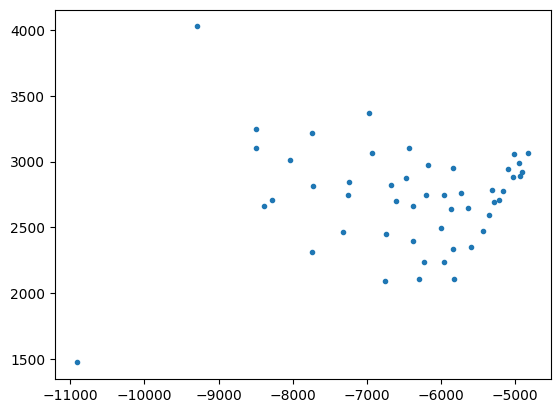

In [27]:
G.nodes().data()
x_vals = [n[1]["x"] for n in G.nodes().data()]
y_vals = [n[1]["y"] for n in G.nodes().data()]
plt.plot(x_vals, y_vals, '.')

## Draw shortest path

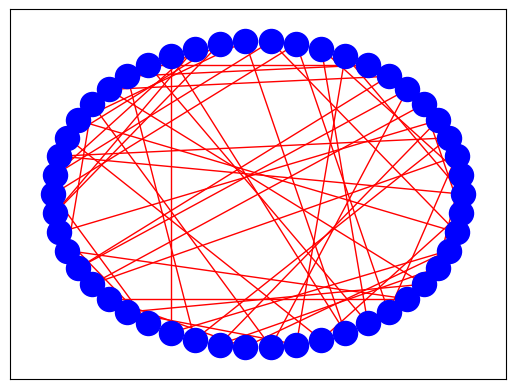

In [28]:
pos = nx.spring_layout(G)
pos = nx.circular_layout(G)


# pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
path_edges = list(zip(tsp_shortest_path, tsp_shortest_path[1:]))
# h = G.subgraph(tsp_shortest_path)
# labels = nx.get_node_attributes(G, 'id')

nx.draw_networkx_nodes(G,pos=pos, node_color='b') #or even nx.draw(h,pos=pos,node_color='b') to get nodes and edges in one command
# nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="b")
nx.draw_networkx_edges(G, edgelist=path_edges, pos=pos, edge_color='r')
# print(path_edges)
# print(labels)

In [29]:
print(G.nodes.data())

[(0, {'x': -5961.513053174005, 'y': 2236.041995790761}), (1, {'x': -9287.821354574531, 'y': 4028.410982687635}), (2, {'x': -7743.816805421991, 'y': 2311.143387140668}), (3, {'x': -6379.680295493998, 'y': 2400.107649091518}), (4, {'x': -8392.976246048636, 'y': 2664.025175599511}), (5, {'x': -7253.950856881725, 'y': 2745.804158594989}), (6, {'x': -5021.665661504875, 'y': 2885.918649422432}), (7, {'x': -5218.571378956087, 'y': 2705.918982955634}), (8, {'x': -5822.883103442604, 'y': 2104.087378276678}), (9, {'x': -5830.983188276846, 'y': 2332.669657971635}), (10, {'x': -10905.10503509802, 'y': 1472.356075480885}), (11, {'x': -8031.5178199525, 'y': 3013.520309123051}), (12, {'x': -6194.452160039679, 'y': 2748.85012353377}), (13, {'x': -5952.431602606583, 'y': 2749.381607390675}), (14, {'x': -6468.79601514302, 'y': 2873.753597507381}), (15, {'x': -6611.764205311191, 'y': 2697.494770355825}), (16, {'x': -5863.673038451106, 'y': 2639.26605678403}), (17, {'x': -6297.394751448061, 'y': 2104.5219

## Experiment with Voronoi